In [30]:
import mlflow
import mlflow.keras
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [31]:
# data
root_path = "/Users/simone/Google Drive/UNISTI/master project/data/dataset2/rgb/"
    
# mlflow
tracking_uri = "file:///Users/simone/mlflow_tracking"
experiment = 'sdp'

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment)

Traceback (most recent call last):
  File "/Users/simone/miniconda3/envs/sdp-modelling/lib/python3.6/site-packages/mlflow/store/file_store.py", line 193, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/Users/simone/miniconda3/envs/sdp-modelling/lib/python3.6/site-packages/mlflow/store/file_store.py", line 247, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/Users/simone/miniconda3/envs/sdp-modelling/lib/python3.6/site-packages/mlflow/utils/file_utils.py", line 159, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/Users/simone/mlflow_tracking/mlruns/meta.yaml' does not exist.
Traceback (most recent call last):
  File "/Users/simone/miniconda3/envs/sdp-modelling/lib/python3.6/site-packages/mlflow/store/file_store.py", line 193, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  Fi

In [14]:
def evaluate_generator(model, generator):
    loss, acc = model.evaluate_generator(generator=generator, steps=len(generator), verbose=1)
    print("Loss value {} and Accuracy value {}".format(loss, acc))
    
def predict_generator(model, generator):
    generator.reset()
    pred = model.predict_generator(generator, steps=len(generator), verbose=1)
    
    predicted_class_indices = np.argmax(pred, axis=1)

    diplay_confusion_matrix(test_generator.classes, predicted_class_indices, test_generator.class_indices)
    display_roc(test_generator.classes, predicted_class_indices)
    
    generator.reset()
    
def diplay_confusion_matrix(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(5.5, 4))
    fig = sns.heatmap(cm_df, annot=True)
    plt.title(' \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return fig

def display_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_val = auc(fpr, tpr)

    fig, ax = plt.subplots()
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc_val))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    return fig
    
def create_generators(data_root):
    gen = ImageDataGenerator(rescale=1./255)
    generator = gen.flow_from_directory(
        data_root + 'test/',
        target_size=(244, 244),
        color_mode='rgb',
        shuffle=False,
        batch_size=1,
        class_mode='categorical',
        seed=1)

    return generator

In [32]:
vgg16_experiment_id = "cc4da1659b2d44d2b6661758141fd7dc"
vgg16_model = mlflow.keras.load_model("runs:/{0}/model".format(vgg16_experiment_id))

# Evaluation

In [33]:
test_generator = create_generators(root_path)

Found 54 images belonging to 2 classes.


In [34]:
evaluate_generator(vgg16_model, test_generator)

54/54 [==============================] - 108s 2s/step
Loss value 0.5969671386335365 and Accuracy value 0.9629629629629629


54/54 [==============================] - 91s 2s/step


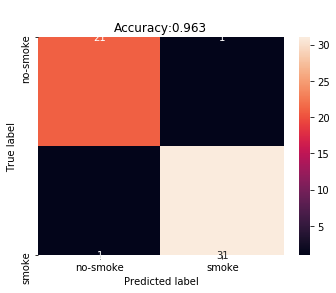

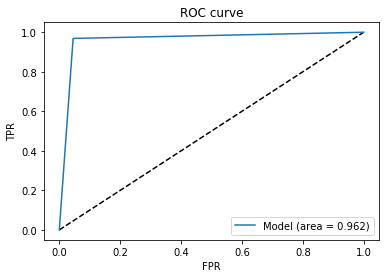

In [35]:
predict_generator(vgg16_model, test_generator)

# Heatmap

In [40]:
smoke_image = root_path + 'test/smoke/cjxhyld313qp10848ql2oq7gp_smoke_0.png'

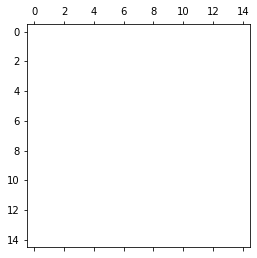

In [41]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from keras import backend as K

img = image.load_img(smoke_image, target_size=(244, 244))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

output = vgg16_model.output[:, 0]
last_conv_layer = vgg16_model.get_layer('block5_conv3')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([vgg16_model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [48]:
grads

<tf.Tensor 'gradients_4/block5_pool_4/MaxPool_grad/MaxPoolGrad:0' shape=(?, 15, 15, 512) dtype=float32>